In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
from arch import arch_model
from scipy.optimize import minimize

In [2]:
data = pd.read_csv('usdata.csv')
data

,obs,FFR,GDP,CPI
0,1954Q3,0.010267,-1.564017,0.153015
1,1954Q4,0.009867,-1.544422,0.152446
2,1955Q1,0.013433,-1.516031,0.151877
3,1955Q2,0.015000,-1.499793,0.151877
4,1955Q3,0.019400,-1.486542,0.152446
...,...,...,...,...
204,2005Q3,0.034600,0.118237,1.117179
205,2005Q4,0.039800,0.122609,1.124005
206,2006Q1,0.044567,0.136186,1.130262
207,2006Q2,0.049067,0.142502,1.151877


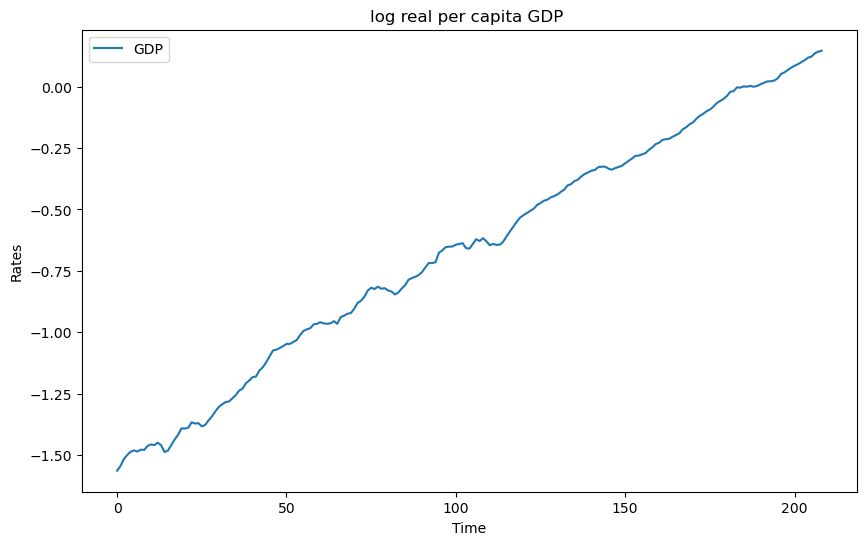

In [3]:
y = data['GDP']


plt.figure(figsize=(10, 6))
plt.plot(y, label='GDP')
plt.title('log real per capita GDP ')
plt.xlabel('Time')
plt.ylabel('Rates')
plt.legend()
plt.show()

####  ${r_t}$ does not seem to be stationary as its mean appears to be time varying. However, there is no apparent deterministic trend.

In [4]:
# delta ffr
dy = y.diff()

# Lag
y_lag = y.shift(1)
dy_lag = dy.shift(1)

trend = np.arange(len(y))

df = pd.DataFrame({
    'y'    : y,
    'dy'   : dy,
    'y_lag': y_lag,
    'trend': trend,
    'dy_lag': dy_lag   
}).dropna()

df

,y,dy,y_lag,trend,dy_lag
2,-1.516031,0.028391,-1.544422,2,0.019595
3,-1.499793,0.016238,-1.516031,3,0.028391
4,-1.486542,0.013251,-1.499793,4,0.016238
5,-1.481228,0.005314,-1.486542,5,0.013251
6,-1.485915,-0.004687,-1.481228,6,0.005314
...,...,...,...,...,...
204,0.118237,0.010246,0.107992,204,0.008031
205,0.122609,0.004372,0.118237,205,0.010246
206,0.136186,0.013577,0.122609,206,0.004372
207,0.142502,0.006316,0.136186,207,0.013577


### We conduct the ADF test ($\tau$) using the following equation : $\Delta y_{t} = \gamma y_{t-1} + \beta \Delta y_{t-1} + \epsilon_{t}$

In [5]:
X = df[['y_lag', 'dy_lag']]
Y = df['dy']

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())
print('Sum of Squared Residuals (SSR):', results.ssr)

                                 OLS Regression Results                                
Dep. Variable:                     dy   R-squared (uncentered):                   0.452
Model:                            OLS   Adj. R-squared (uncentered):              0.447
Method:                 Least Squares   F-statistic:                              84.58
Date:                Mon, 25 Sep 2023   Prob (F-statistic):                    1.65e-27
Time:                        19:48:52   Log-Likelihood:                          680.76
No. Observations:                 207   AIC:                                     -1358.
Df Residuals:                     205   BIC:                                     -1351.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The $\tau$ statistic: No Constant or Time Trend (a0 = a2 = 0)

#### critical values for sample size T = 250 are: 

-1.95 at 5% significant level 

-1.62 at 10% significant level

So we reject the null!

### We conduct the ADF test ($\tau_{\mu}$) using the following equation : $\Delta y_{t} = a_{0} + \gamma y_{t-1} + \beta \Delta y_{t-1} + \epsilon_{t}$

In [6]:
X = df[['y_lag', 'dy_lag']]
X = sm.add_constant(X)
Y = df['dy']

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())
print('Sum of Squared Residuals (SSR):', results.ssr)

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     10.38
Date:                Mon, 25 Sep 2023   Prob (F-statistic):           5.11e-05
Time:                        19:49:13   Log-Likelihood:                 690.14
No. Observations:                 207   AIC:                            -1374.
Df Residuals:                     204   BIC:                            -1364.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0050      0.001      4.400      0.0

The $\tau_{\mu}$ statistic: Constant but No Time Trend (a2 = 0)

#### critical values for sample size T = 250 are: 

-2.88 at 5% significant level 

-2.58 at 10% significant level

So we fail to reject the null!

### We conduct the ADF test ($\tau_{\tau}$) using the following equation : $\Delta y_{t} = a_{0} + \gamma y_{t-1} + a_{2}t + \beta \Delta y_{t-1} + \epsilon_{t}$

In [7]:
X = df[['y_lag', 'trend', 'dy_lag']]
X = sm.add_constant(X)
Y = df['dy']

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())
print('Sum of Squared Residuals (SSR):', results.ssr)

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     8.979
Date:                Mon, 25 Sep 2023   Prob (F-statistic):           1.30e-05
Time:                        19:49:39   Log-Likelihood:                 693.01
No. Observations:                 207   AIC:                            -1378.
Df Residuals:                     203   BIC:                            -1365.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0538      0.025     -2.184      0.0

The $\tau_\tau$ statistic: Constant + Time Trend

#### critical values for sample size T = 250 are: 

-3.43 at 5% significant level 

-3.13 at 10% significant level

### So we fail reject the null! we can conclude the series has at least one unit root. We continue further with $\Phi_2$ and $\Phi_3$  tests for the option of a deterministic trend in addition to the stochastic trend.

In [8]:
def F_statistic(SSR_restricted, SSR_unrestricted, r, T, k):
    phi = ((SSR_restricted - SSR_unrestricted)/r)/(SSR_unrestricted/(T - k))
    return phi

'''
r = number of restrictions
T = number of usable observations
k = number of parameters estimated in the unrestricted model
'''

'\nr = number of restrictions\nT = number of usable observations\nk = number of parameters estimated in the unrestricted model\n'

### Unrestricted model:
$\Delta y_{t} = a_{0} + \gamma y_{t-1} + a_{2}t + \beta \Delta y_{t-1}+ \epsilon_{t}$

In [9]:
X = df[['y_lag','trend', 'dy_lag']]
X = sm.add_constant(X)
Y = df['dy']

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())
print('Sum of Squared Residuals (SSR) for restricted model:', results.ssr)
SSR_unrestricted = results.ssr

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     8.979
Date:                Mon, 25 Sep 2023   Prob (F-statistic):           1.30e-05
Time:                        19:50:19   Log-Likelihood:                 693.01
No. Observations:                 207   AIC:                            -1378.
Df Residuals:                     203   BIC:                            -1365.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0538      0.025     -2.184      0.0

### restricted model: 
$\Delta y_{t} = \beta \Delta y_{t-1} + \epsilon_{t}$

In [10]:
X = df[['dy_lag']]
Y = df['dy']

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())
print('Sum of Squared Residuals (SSR) for restricted model:', results.ssr)
SSR_restricted_phi_2 = results.ssr

                                 OLS Regression Results                                
Dep. Variable:                     dy   R-squared (uncentered):                   0.377
Model:                            OLS   Adj. R-squared (uncentered):              0.374
Method:                 Least Squares   F-statistic:                              124.5
Date:                Mon, 25 Sep 2023   Prob (F-statistic):                    6.47e-23
Time:                        19:50:20   Log-Likelihood:                          667.40
No. Observations:                 207   AIC:                                     -1333.
Df Residuals:                     206   BIC:                                     -1329.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [11]:
#%% Phi 2
'''
r = number of restrictions
T = number of usable observations
k = number of parameters estimated in the unrestricted model
'''
r = 3
T = len(df)
k = 4
phi_2 = F_statistic(SSR_restricted_phi_2, SSR_unrestricted, r, T, k)
print('phi_2 statistics = {}'.format(phi_2))

phi_2 statistics = 18.995392490068753


The $\Phi_2 statistic: 

#### critical values for sample size T = 250 are: 

4.75 at 5% significant level 

4.07 at 10% significant level

#### So we fail reject the null! 

### restricted model: 
$\Delta y_{t} = a_{0} + \beta \Delta y_{t-1} + \epsilon_{t}$

In [12]:
X = df[['dy_lag']]
X = sm.add_constant(X)
Y = df['dy']

model = sm.OLS(Y, X)
results = model.fit()

print(results.summary())
print('Sum of Squared Residuals (SSR) for restricted model:', results.ssr)
SSR_restricted_phi_3 = results.ssr

                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     19.90
Date:                Mon, 25 Sep 2023   Prob (F-statistic):           1.34e-05
Time:                        19:50:25   Log-Likelihood:                 689.70
No. Observations:                 207   AIC:                            -1375.
Df Residuals:                     205   BIC:                            -1369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0057      0.001      7.021      0.0

In [13]:
#%% Phi 3
'''
r = number of restrictions
T = number of usable observations
k = number of parameters estimated in the unrestricted model
'''
r = 2
T = len(df)
k = 4
phi_3 = F_statistic(SSR_restricted_phi_3, SSR_unrestricted, r, T, k)
print('phi_3 statistics = {}'.format(phi_3))

phi_3 statistics = 3.2963174487787548


The $\Phi_3 statistic: 

#### critical values for sample size T = 250 are: 

5.39 at 5% significant level 

6.34 at 10% significant level

#### So we fail to reject the null! 

### Putting all these test results together, we can conclude that $\{y_{t}\}$ is likely to have unit roots and a drift, but not likely to have a deterministic trend.

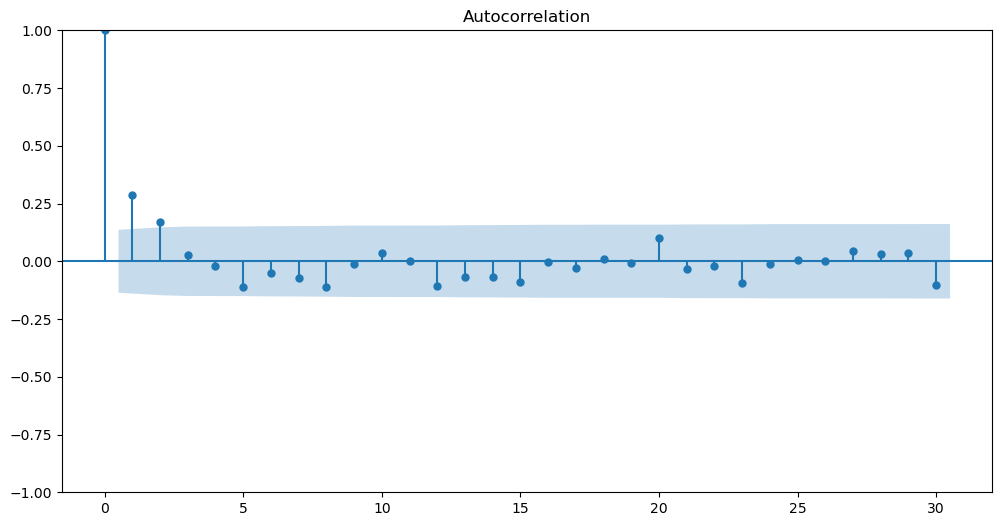

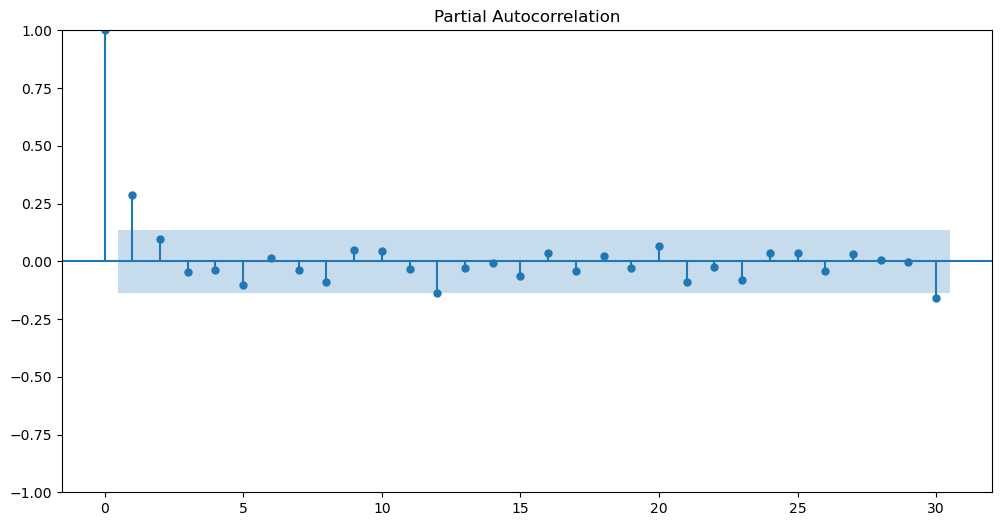

In [14]:
# Plot ACF
ts = df['dy']
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_acf(ts.values.squeeze(), lags=30, ax=ax)
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.tsa.plot_pacf(ts.values.squeeze(), lags=30, ax=ax)
plt.show()

### Therefore, we consider ARIMA(0, 1, 1), ARIMA(0, 1, 2), ARIMA(1, 1, 2) for $\{y_{t}\}$

### ARIMA(1, 1, 1)

In [15]:
ts = data['FFR']
p = 0
d = 1
q = 1
model1 = sm.tsa.ARIMA(ts, order=(p, d, q)).fit()
print('ARIMA(0,1,1) Model aic:', model1.aic) 
print('ARIMA(0,1,1) Model bic:', model1.bic)

ARIMA(0,1,1) Model aic: -1364.3358300906484
ARIMA(0,1,1) Model bic: -1357.6607539312458


In [16]:
ts = data['FFR']
p = 0
d = 1
q = 2
model2 = sm.tsa.ARIMA(ts, order=(p, d, q)).fit()
print('ARIMA(0,1,2) Model aic:', model2.aic) 
print('ARIMA(0,1,2) Model bic:', model2.bic)

ARIMA(0,1,2) Model aic: -1368.9409241868902
ARIMA(0,1,2) Model bic: -1358.9283099477864


In [17]:
ts = data['FFR']
p = 1
d = 1
q = 2
model3 = sm.tsa.ARIMA(ts, order=(p, d, q)).fit()
print('ARIMA(1,1,2) Model aic:', model3.aic) 
print('ARIMA(1,1,2) Model bic:', model3.bic)

ARIMA(1,1,2) Model aic: -1366.3674498460496
ARIMA(1,1,2) Model bic: -1353.0172975272444


### We choose ARIMA(0, 1, 2) as it has the smallest AIC and BIC.

In [19]:
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                    FFR   No. Observations:                  209
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 687.470
Date:                Mon, 25 Sep 2023   AIC                          -1368.941
Time:                        20:00:11   BIC                          -1358.928
Sample:                             0   HQIC                         -1364.892
                                - 209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3373      0.043      7.876      0.000       0.253       0.421
ma.L2         -0.1691      0.038     -4.467      0.000      -0.243      -0.095
sigma2      7.869e-05   3.58e-06     21.961      0.0